# Language Detection using NLP.

In [67]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support


from scipy.sparse import csr_matrix


In [68]:
# Unzip the data file and load the csv.
import zipfile

zip_file_path = '/content/Language Detection.csv.zip'
csv_file_name = 'Language Detection.csv'  # Update this with the actual CSV file name inside the zip

# Unzip the CSV file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(csv_file_name, extract_path)


df = pd.read_csv(f'{extract_path}{csv_file_name}')

In [69]:
df.sample(10)

,Text,Language
789,They attempted to approach the problem with va...,English
1092,if you haven't already press the subscribe but...,English
8312,[10] Den äldsta bevarade startsidan[11] för Sv...,Sweedish
10227,ಈ ರಾತ್ರಿ ನೀನೇನು ಮಾಡುತ್ತಿದ್ದೀಯಾ?,Kannada
7493,posso sempre dirlo perché non avevo Sono stato...,Italian
7088,"blev klar til seng mor, jeg håber virkelig min...",Danish
5791,"κάποιος είναι απασχολημένος, μπορείς πάντα να ...",Greek
4885,[55]​[56]​[57]​ Cada Wikipedia según idioma es...,Spanish
6124,Википедия не лишена недостатков.,Russian
6817,hvis du ikke allerede har trykket på abonnemen...,Danish


In [70]:
df.size

20674

In [71]:
df.shape

(10337, 2)

In [72]:
df.Language.value_counts()

Language
English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil          469
Danish         428
Kannada        369
Greek          365
Hindi           63
Name: count, dtype: int64

In [73]:
df.Language.nunique()

17

## Here we have total 17 unique langauges.

In [74]:
# Check for duplicates:-

df[df.duplicated()]

,Text,Language
1141,i'm sorry.,English
1180,oh my god.,English
1196,i'm sorry.,English
1724,എന്നോട് ക്ഷമിക്കൂ.,Malayalam
1767,ഓ എന്റെ ദൈവമേ.,Malayalam
...,...,...
9706,Ach du lieber Gott.,German
9726,Es tut mir Leid.,German
10081,ನನ್ನನ್ನು ಕ್ಷಮಿಸು.,Kannada
10125,ಓ ದೇವರೇ.,Kannada


In [75]:
# There are 66 duplicate rows, droping them

df.drop(df[df.duplicated()].index, axis=0, inplace=True)

In [76]:
df.shape

(10271, 2)

### Let's visualize the data.

<ipython-input-77-e5d59ca4157d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Language', data=df, palette='viridis', order=df['Language'].value_counts().index)


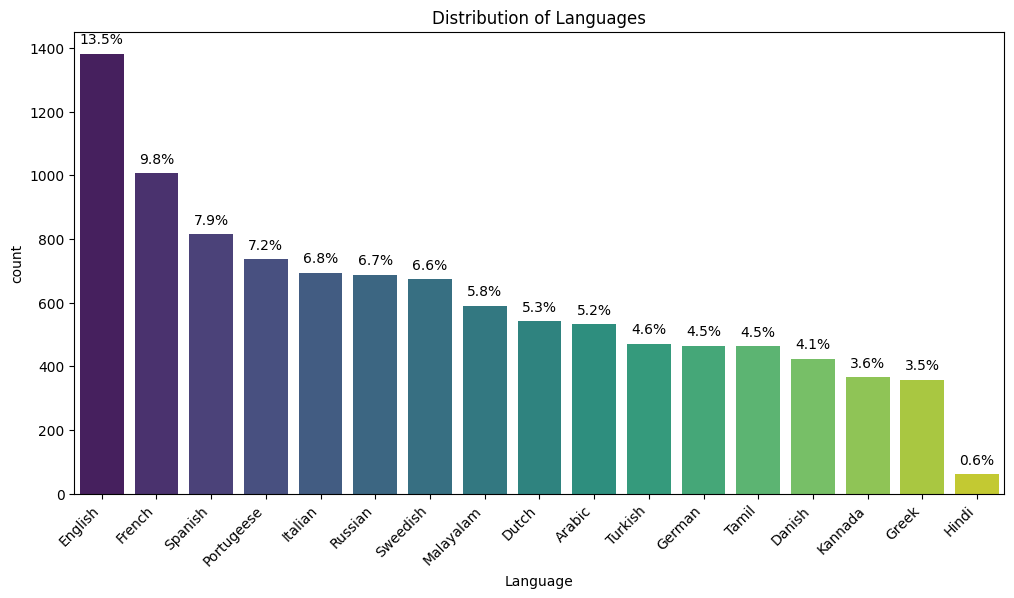

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axis
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Language', data=df, palette='viridis', order=df['Language'].value_counts().index)
plt.title('Distribution of Languages')
plt.xticks(rotation=45, ha='right')

total = len(df)

# Add percentage annotations
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.show()


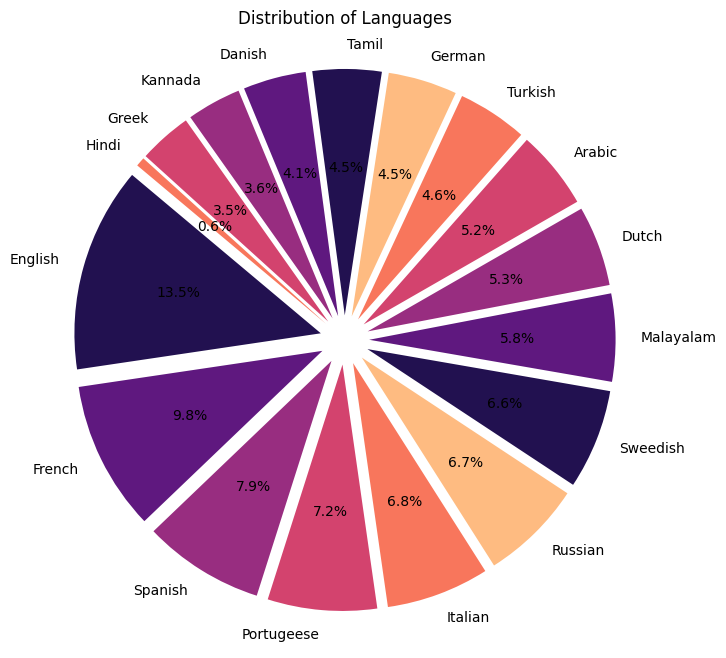

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pie plot
plt.figure(figsize=(8, 8))
df['Language'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140,
                                       colors=sns.color_palette('magma'),
                                       explode=[0.1] * df['Language'].nunique())
plt.title('Distribution of Languages')
plt.ylabel('')  # Remove the default ylabel
plt.show()


In [79]:
# Make a copy first.
data= df.copy()
data['Cleaned_Text']= ""
data

,Text,Language,Cleaned_Text
0,"Nature, in the broadest sense, is the natural...",English,
1,"""Nature"" can refer to the phenomena of the phy...",English,
2,"The study of nature is a large, if not the onl...",English,
3,"Although humans are part of nature, human acti...",English,
4,[1] The word nature is borrowed from the Old F...,English,
...,...,...,...
10332,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...,Kannada,
10333,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...,Kannada,
10334,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...,Kannada,
10335,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...,Kannada,


# Data Cleaning.

In [80]:
data.isnull().mean()

Text            0.0
Language        0.0
Cleaned_Text    0.0
dtype: float64

In [81]:
import re

def clean_text(text):
    # Remove symbols, numbers, URLs, RT, cc, hashtags, mentions, and extra whitespace
    text = re.sub(r'[\([{})\]!@#$,"%^*?:;~`0-9]', ' ', text)  # Remove symbols and numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub('http\S+\s*', ' ', text)  # Remove URLs
    text = re.sub('RT|cc', ' ', text)  # Remove RT and cc
    text = re.sub('#\S+', '', text)  # Remove hashtags
    text = re.sub('@\S+', ' ', text)  # Remove mentions
    text = re.sub('\s+', ' ', text).strip()  # Remove extra whitespace and strip leading/trailing spaces

    return text


In [82]:
data['Cleaned_Text'] = data['Text'].apply(lambda x: clean_text(x))
data

,Text,Language,Cleaned_Text
0,"Nature, in the broadest sense, is the natural...",English,nature in the broadest sense is the natural ph...
1,"""Nature"" can refer to the phenomena of the phy...",English,nature can refer to the phenomena of the physi...
2,"The study of nature is a large, if not the onl...",English,the study of nature is a large if not the only...
3,"Although humans are part of nature, human acti...",English,although humans are part of nature human activ...
4,[1] The word nature is borrowed from the Old F...,English,the word nature is borrowed from the old frenc...
...,...,...,...
10332,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...,Kannada,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...
10333,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...,Kannada,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...
10334,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...,Kannada,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...
10335,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...,Kannada,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...


In [83]:
# Split data.

X= data["Cleaned_Text"]
y= data["Language"]

In [93]:
# For the target column, perforing labeling to convert text into numbers.
from sklearn.preprocessing import LabelEncoder

def label_data(y):
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    return y_encoded


In [85]:
#spliting data into train  and test

def split_data(X,y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [86]:
# Text Vectorization

def vectorize_data(X_train, X_test, max_features=5000):
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    return X_train_tfidf, X_test_tfidf

In [87]:
# model training and evaluting.

def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Model evaluation
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    classification_rep = classification_report(y_test, y_test_pred)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Print results
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print("Classification Report:\n", classification_rep)

    # Save results to DataFrame
    results = {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Classification Report': classification_rep
    }
    # save_results(results, f"{model_name}_results.csv")
    return results, conf_matrix

In [88]:
# Modify the vectorize_data function to reorder sparse matrices for ANN model

import tensorflow as tf

def vectorize_data2(X_train, X_test):
    # Convert sparse matrices to TensorFlow Sparse Tensors
    X_train_reordered = tf.convert_to_tensor(csr_matrix(X_train).todense(), dtype=tf.float32)

    X_test_reordered = tf.convert_to_tensor(csr_matrix(X_test).todense(), dtype=tf.float32)


    return X_train_reordered, X_test_reordered

In [89]:
# Trian ANN model and evalution:-

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

def train_ann(X_train, y_train):
    ann_model = Sequential()
    ann_model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
    ann_model.add(Dense(units=64, activation='relu'))
    ann_model.add(Dense(units=len(np.unique(y_train)), activation='softmax'))

    ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    ann_model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

    return ann_model



In [90]:
# To save model result .

import pandas as pd
import numpy as np

def save_results(results, conf_matrices, filename='model_results.csv'):

    rows = []

     # Populate the list with model results
    for model_name, result in results.items():
        train_accuracy = result['Train Accuracy']
        test_accuracy = result['Test Accuracy']
        classification_report_str = result['Classification Report']

        # Calculate precision, recall, and F1 score from confusion matrix
        conf_matrix = conf_matrices[model_name]
        precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
        recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
        f1_score = 2 * (precision * recall) / (precision + recall)

        rows.append({
            'Model': model_name,
            'Train Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy,
            'Precision': np.mean(precision),
            'Recall': np.mean(recall),
            'F1 Score': np.mean(f1_score),
            'Classification Report': classification_report_str
        })

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(rows)

    df.to_csv(filename, index=False)
    print(f"Results saved to '{filename}'")



In [91]:
def evaluate_ann(ann_model, X_test, y_test):

    loss, accuracy = ann_model.evaluate(X_test, y_test, verbose=1)
    y_pred = np.argmax(ann_model.predict(X_test), axis=-1)

    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    classification_report_str = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")
    print("Classification Report:\n", classification_report_str)

    return {'Test Loss': loss,
            'Test Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score}, conf_matrix

In [94]:
def main():

    y_lab = label_data(y)

    # Train-Test Split
    X_train, X_test, y_train, y_test = split_data(X, y_lab)

    # Vectorization
    X_train_tfidf, X_test_tfidf = vectorize_data(X_train, X_test)

    # Model Training and Evaluation
    models = {
        'Logistic Regression': LogisticRegression(C=1.0, solver='liblinear', max_iter=100, random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
        'Naive Bayes': MultinomialNB(alpha=1.0)
    }

    results = {}
    conf_matrices = {}

    for model_name, model in models.items():
        print(f"\n\n\nTraining and evaluating {model_name}...")
        result, conf_matrix = train_evaluate_model(model, X_train_tfidf, X_test_tfidf, y_train, y_test)
        results[model_name] = result
        conf_matrices[model_name] = conf_matrix

    # Train and Evaluate ANN
    X_train_reordered, X_test_reordered = vectorize_data2(X_train_tfidf, X_test_tfidf)
    ann_model = train_ann(X_train_reordered, y_train)
    ann_results, ann_conf_matrix = evaluate_ann(ann_model, X_test_reordered, y_test)

    results['Artificial Neural Network (ANN)'] = ann_results

    # Initialize the conf_matrices dictionary if it's not defined yet
    if 'conf_matrices' not in locals():
        conf_matrices = {}

    conf_matrices['Artificial Neural Network (ANN)'] = ann_conf_matrix

    print("\n\n\nTraining and evaluating Artificial Neural Network (ANN)...")
    print("Results:", ann_results)
    print("Confusion Matrix:", ann_conf_matrix)

    # Save results to CSV file
    # save_results(results, conf_matrices)

main()





Training and evaluating Logistic Regression...
Train Accuracy: 0.9709104186952289
Test Accuracy: 0.9537712895377128
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       121
           1       0.96      0.93      0.95        85
           2       0.98      0.93      0.95       108
           3       0.96      0.99      0.98       290
           4       1.00      0.94      0.97       210
           5       1.00      0.94      0.97        86
           6       1.00      0.95      0.98        65
           7       1.00      0.75      0.86         8
           8       0.99      0.93      0.96       130
           9       1.00      0.96      0.98        70
          10       1.00      0.99      1.00       122
          11       0.97      0.96      0.96       139
          12       0.65      1.00      0.79       119
          13       0.96      0.96      0.96       160
          14       0.98      0.95      0.96   

# Conclusion :-
### Logistic Regression:
- **Train Accuracy**: 97.09%
- **Test Accuracy**: 95.38%
- **Key Insights**: Achieved high accuracy across most classes, particularly strong performance in classes 0, 3, 10, and 16.

### K-Nearest Neighbors:
- **Train Accuracy**: 51.22%
- **Test Accuracy**: 37.08%
- **Key Insights**: Significantly lower performance compared to other models, particularly poor in classes 0, 4, and 16.

### Random Forest:
- **Train Accuracy**: 97.50%
- **Test Accuracy**: 94.11%
- **Key Insights**: High accuracy overall, struggled slightly in classifying class 16.

### Naive Bayes:
- **Train Accuracy**: 96.41%
- **Test Accuracy**: 96.01%
- **Key Insights**: Balanced performance across all classes, particularly strong recall in most classes.

### Artificial Neural Network (ANN):
- **Test Loss**: 0.135
- **Test Accuracy**: 95.96%
- **Precision**: 96.76%
- **Recall**: 95.96%
- **F1 Score**: 96.14%
- **Key Insights**: Achieved high accuracy and balanced performance across all classes, slightly better than logistic regression.

Overall, Naive Bayes and the Artificial Neural Network outperformed the other models in terms of both accuracy and F1 score. However, considering the complexity and computational resources required, Logistic Regression and Random Forest also showed commendable performance. K-Nearest Neighbors, on the other hand, demonstrated the weakest performance, indicating that its simplistic approach might not be suitable for this classification task.

This analysis provides valuable insights into the strengths and weaknesses of each model, helping guide future decisions on model selection and optimization.